# Rewrite Code - Diffusion model
改變：
1. 新增validation loss
2. LR再往下1/10

sorce code: Simple file

**目標**
* 利用neural network生成y_hat資料
* 比對y_true : 一堆N(0,1)生成的點(假裝不知道是normal)
* 假設檢定看y_hat跟y_true是否來自相同母群

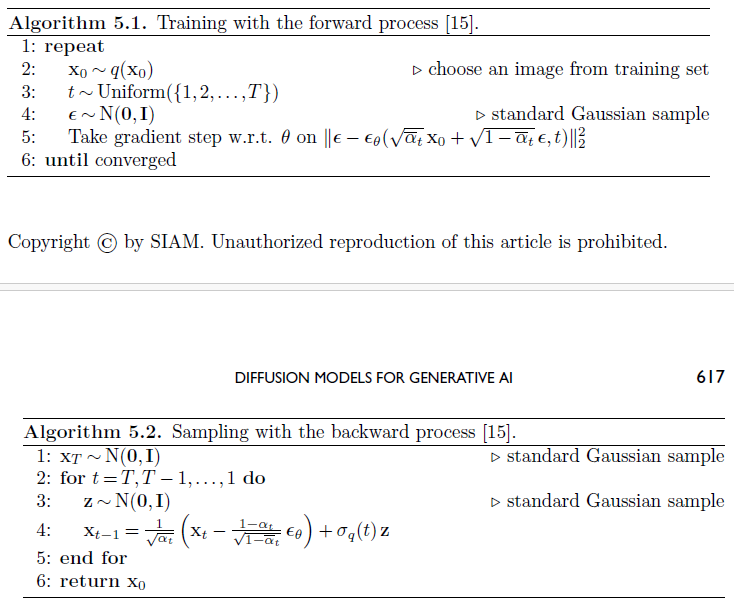


## 10.22 修改部分
1. 當loss震動的時候lr下降10

In [1]:
import math, torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

### Con fig

In [2]:
DEVICE        = 'cpu' 
T             = 500        # diffusion steps
BATCH_SIZE    = 1024
TRAIN_ITERS   = 2000       # 訓練步數
LR            = 5e-4       # 10.09 調降1/10
HIDDEN        = 512
TIME_DIM      = 64
N_TRAIN_SAMP  = 10000       # 訓練資料量）


In [3]:
### Constants setting
betas = torch.linspace(1e-4, 0.02, T+1, device=DEVICE)
alphas = 1.0-betas
abar = torch.cumprod(alphas, dim=0)
sqrt_abar = torch.sqrt(abar)
sqrt_lmabar = torch.sqrt(1.0-abar)
sqrt_rcp_a = torch.sqrt(1.0 / alphas)

In [4]:
### 這塊留給 time embedding
#-------------------------
def sinusoidal_time_emb(t, dim):
    # t: (B,) 的整數 timestep
    device = t.device
    t = t.float().unsqueeze(1)  # (B,1)
    half = dim // 2
    freqs = torch.exp(
        torch.arange(half, device=device).float() * (-math.log(10000.0) / max(1, half-1))
    )  # (half,)
    angles = t * freqs  # (B,half)
    emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=1)  # (B, 2*half)
    if dim % 2 == 1:  # 補一維避免奇數維崩
        emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=1)
    return emb  # (B, dim)

In [24]:
## 建nn
class EpsMLP(nn.Module):
    def __init__(self, hidden=HIDDEN, time_dim=TIME_DIM):
        super().__init__()
        self.time_dim = time_dim
        # 把 time embedding 投影到hidden layer
        self.t_proj = nn.Sequential(
            nn.Linear(time_dim, hidden), 
            nn.SiLU()
            )
        
        # y_t(1維) + time(hidden) → hidden → 1維噪聲預測
        in_dim = hidden + 1 # y+dim=1
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden,1)
        )
    def forward(self, y_t, t):
        t_emb = sinusoidal_time_emb(t, self.time_dim)   # (B, time_dim)
        h_t = self.t_proj(t_emb)                        # (B, hidden)
        h = torch.cat([y_t, h_t], dim=1)                # (B, 1+hidden)
        return self.net(h)

model = EpsMLP().to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=TRAIN_ITERS, eta_min=1e-5)  ###<---10/1新增
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt,                      # 你的 optimizer
    mode='min',               # 要最小化的 metric（通常是 loss）
    factor=0.5,               # 沒改善時學習率乘上這個係數
    patience=80,              # 容忍多少次沒改善才觸發下降
    threshold=1e-3,           # 改善要超過多少幅度才算「有改善」
    threshold_mode='rel',     
    cooldown=10,               # 降完後等幾步再開始監控
    min_lr=1e-10,             # LR 不降到 0 以下
    verbose=True
)    ### <====10/22新增 下降lr用的scheduler

### ReduceLROnPlateau -> 現在LR下降使用的scheduler
> 它不是每次都改 LR，而是「根據你的 metric（通常是 validation loss）」決定要不要降 LR。  

所以：
1. 每次算出 validation loss；
2. 拿這個 loss 給 scheduler；
3. scheduler 根據「最近的最佳表現」判斷要不要降 LR；
4. 如果超過 patience 沒改善 → 乘 factor；
5. 你用 opt.param_groups[0]['lr'] 就能看到新學習率。



###  CosineAnnealingLR
新增了這個步驟，意思是lr會隨著訓練step沿著一條餘弦曲線下降。Annealing就是會讓lr逐步減小，讓系統穩定下來。$$\eta_t=\eta_{min}+\frac{1}{2}(\eta_{max}-\eta_{min})(1+\cos(\frac{T_{now}}{T_{max}}\pi))$$

In [25]:
### 計算 y_t= sqrt(abar_t) y0 + sqrt(1-abar_t) * eps
# ---------------------
def q_sample(y0, t, eps=None):
    if eps is None:
        eps = torch.randn_like(y0)   ## 產生跟y0大小一樣的初始normal雜訊
    sa = sqrt_abar[t].view(-1,1)
    som = sqrt_lmabar[t].view(-1,1)
    return sa*y0+som*eps, eps


## Validation Loss

In [20]:
# ===== Validation setup (one-time) =====
VAL_SIZE = BATCH_SIZE  # 你也可改成 2*BATCH_SIZE 或 1024
g = torch.Generator(device=DEVICE).manual_seed(20251008)  # 固定種子

y0_val = torch.randn(VAL_SIZE, 1, generator=g, device=DEVICE)
t_val  = torch.randint(2, T+1, (VAL_SIZE,), generator=g, device=DEVICE)

@torch.no_grad()
def compute_val_loss():
    model.eval()
    y_t_val, eps_val = q_sample(y0_val, t_val)
    eps_hat_val = model(y_t_val, t_val)
    val_loss = F.mse_loss(eps_hat_val, eps_val)
    model.train()
    return float(val_loss.item())


### 10/22 新增 -> EMA(指數移動平均)
用 EMA 權重做驗證，會讓 val loss 明顯平滑、提升樣本品質（diffusion 常用）。

In [26]:
class WeightEMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.params = [p for p in model.parameters() if p.requires_grad]
        self.shadow = [p.detach().clone() for p in self.params]
        self.backup = None

    @torch.no_grad()
    def update(self):
        for s, p in zip(self.shadow, self.params):
            s.mul_(self.decay).add_(p, alpha=1 - self.decay)

    @torch.no_grad()
    def apply_shadow(self):
        self.backup = [p.detach().clone() for p in self.params]
        for p, s in zip(self.params, self.shadow):
            p.copy_(s)

    @torch.no_grad()
    def restore(self):
        for p, b in zip(self.params, self.backup):
            p.copy_(b)
        self.backup = None


## 10/22新增 lr下降1/10

## Algorithm 1
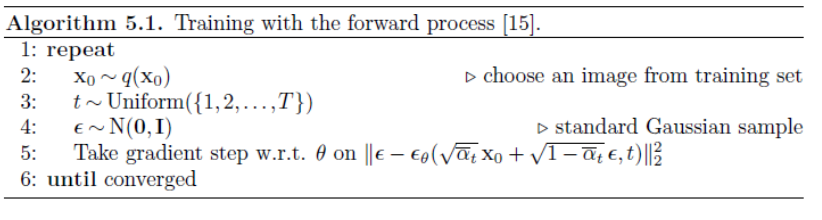

In [27]:
def train_loop(record_step):
    model.train()
    losses =[]
    movavg =[]
    val_hist = [] ##<<<- 10.09 validation loss 新增
    ma=deque(maxlen=50) #長度為50的mov_avg frame
    lr_list=[]
    ema = WeightEMA(model, decay=0.999)

    for step in range(1, TRAIN_ITERS+1):
        # 取 y0~N(0,1)
        y0 = torch.randn(BATCH_SIZE, 1, device=DEVICE)
        # 隨機time step
        t = torch.randint(2,T+1, (BATCH_SIZE,),device=DEVICE).long()
        # 向前加噪
        y_t, eps = q_sample(y0,t)
        # 預測噪音
        eps_hat = model(y_t, t)     
        loss = F.mse_loss(eps_hat, eps)

        opt.zero_grad(set_to_none = True) 
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # 建議保留
        
        opt.step()
        opt.zero_grad(set_to_none=True)  #<<<<<<<<<<
        ema.update()  # 每步更新一次 EMA<<<<<<<<<<<<<

        # （刪掉舊的 scheduler.step()，因為 ReduceLROnPlateau 要吃 metric）


        if step % record_step ==0: 
            val = loss.detach().item()
            losses.append(val)
            ma.append(val)
            movavg.append(sum(ma)/len(ma))
            ### <------> validation loss
            # 驗證時用 EMA 權重：
            ema.apply_shadow()  #<<<<<<<<<<<<<<
            v = compute_val_loss()
            ema.restore()       #<<<<<<<<<<<<<<<
            val_hist.append(v)
            print(f"[train] step {step:4d} | loss {loss.item():.6f} | val {v:.6f}")

            ### <-------- 這裡餵validation loss 給scheduler
            
            scheduler.step(v)
            print(f"Step {step}: LR = {opt.param_groups[0]['lr']:.2e}")
            lr_list.append(opt.param_groups[0]['lr'])

    
    return losses, movavg, val_hist, lr_list

## Algorithm 2
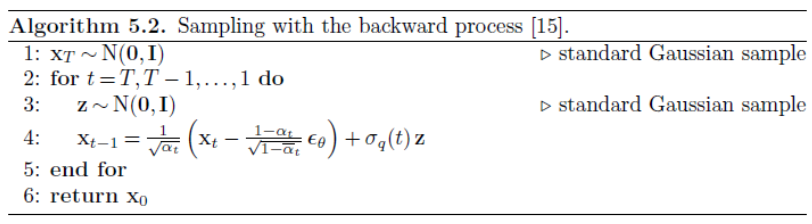

In [22]:
#@torch.no_grad() 是 PyTorch 的一個 decorator（裝飾器），加在函式前面，意思是：
#在這個函式裡面所有的張量運算，都不會被 autograd 記錄梯度。
#這樣可以減少計算消耗

@torch.no_grad()
def sample_on_grid(n_points = 401):
    model.eval()
    # 初始化 y 的 batch，要用 n_points
    y = torch.randn(n_points, 1, device=DEVICE)  ## 直接在N(0,1)裡面抽東西就好
    for t in reversed(range(T+1)):
        tb = torch.full((n_points,), t, device=DEVICE, dtype=torch.long)
        eps_hat = model(y, tb)  ###<<<---已拿掉x
        mean = sqrt_rcp_a[t]*(y - (betas[t]/sqrt_lmabar[t]) * eps_hat) #那行公式
        if t>0:
            y = mean + torch.sqrt(betas[t])*torch.randn_like(y)
        ###<----拿掉else
    
    return y.squeeze(1).cpu() 

---

## TEST

[train] step    1 | loss 1.015525 | val 0.917716
Step 1: LR = 5.00e-04
[train] step    2 | loss 1.013842 | val 0.991139
Step 2: LR = 5.00e-04
[train] step    3 | loss 0.955651 | val 0.950495
Step 3: LR = 5.00e-04
[train] step    4 | loss 0.930493 | val 0.906508
Step 4: LR = 5.00e-04
[train] step    5 | loss 0.909786 | val 0.916954
Step 5: LR = 5.00e-04
[train] step    6 | loss 0.887537 | val 0.827122
Step 6: LR = 5.00e-04
[train] step    7 | loss 0.841363 | val 0.781443
Step 7: LR = 5.00e-04
[train] step    8 | loss 0.828229 | val 0.808044
Step 8: LR = 5.00e-04
[train] step    9 | loss 0.795796 | val 0.807158
Step 9: LR = 5.00e-04
[train] step   10 | loss 0.754961 | val 0.725984
Step 10: LR = 5.00e-04
[train] step   11 | loss 0.721745 | val 0.734135
Step 11: LR = 5.00e-04
[train] step   12 | loss 0.687177 | val 0.662816
Step 12: LR = 5.00e-04
[train] step   13 | loss 0.653015 | val 0.573604
Step 13: LR = 5.00e-04
[train] step   14 | loss 0.618475 | val 0.644760
Step 14: LR = 5.00e-04
[

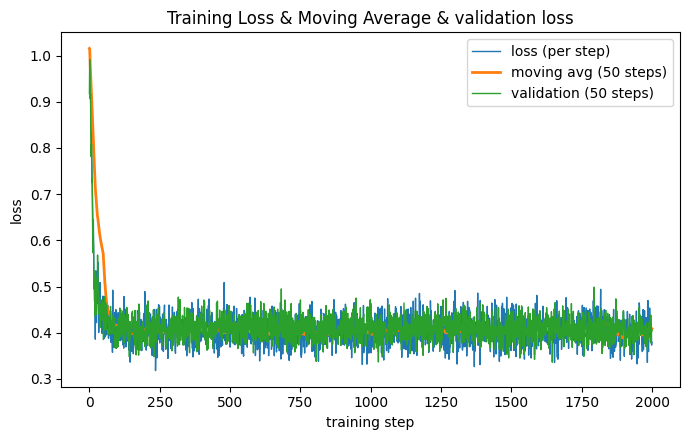

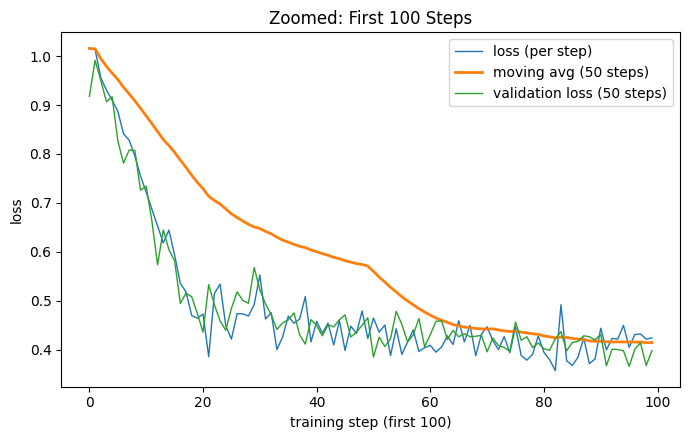

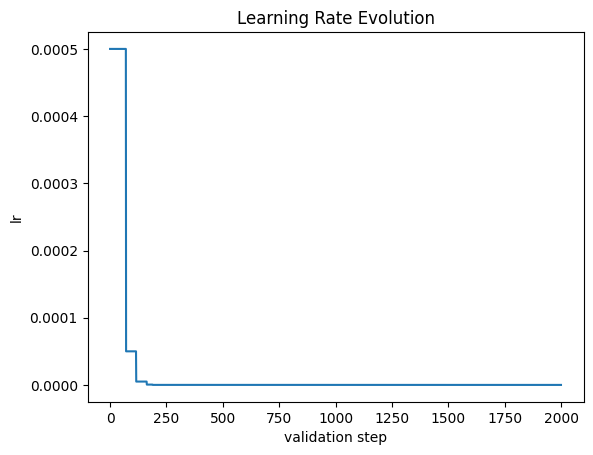

In [23]:
lr_list=[]
losses, movavg, val_hist, lr_list=train_loop(record_step=1)  ### 1 -> 10
steps = np.arange(len(losses))
y_hat = sample_on_grid(n_points = 1000)

# 全部步數
plt.figure(figsize=(7,4.5))
plt.plot(steps, losses, label="loss (per step)", linewidth=1)
plt.plot(steps, movavg, label="moving avg (50 steps)", linewidth=2)
plt.plot(steps, val_hist, label="validation (50 steps)", linewidth=1)
plt.xlabel("training step")
plt.ylabel("loss")
plt.title("Training Loss & Moving Average & validation loss")
plt.legend()
plt.tight_layout()
plt.show()

# 前 100 步局部放大（線性 y 軸）
k = min(100, len(losses))
plt.figure(figsize=(7,4.5))
plt.plot(steps[:k], losses[:k], label="loss (per step)", linewidth=1)
plt.plot(steps[:k], movavg[:k], label="moving avg (50 steps)", linewidth=2)
plt.plot(steps[:k], val_hist[:k], label="validation loss (50 steps)", linewidth=1)
plt.xlabel("training step (first 100)")
plt.ylabel("loss")
plt.title("Zoomed: First 100 Steps")
plt.legend()
plt.tight_layout()
plt.show()


plt.plot(lr_list)
plt.title("Learning Rate Evolution")
plt.xlabel("validation step")
plt.ylabel("lr")
plt.show()

In [11]:
print(type(opt))
for i, g in enumerate(opt.param_groups):
    print(f"group {i} lr={g['lr']}")

<class 'torch.optim.adamw.AdamW'>
group 0 lr=1e-06


### 10/01小結:
對於訓練模型有好結果，從毫無下降到明顯下降。

In [13]:
y_true = torch.randn(1000, 1, device=DEVICE)

print("y_hat: ", y_hat)
print("y_true: ", y_true)   

y_hat:  tensor([ 1.6384e+00, -6.7926e-01,  7.4141e-01,  1.4200e+00,  7.0244e-01,
        -1.6056e+00, -6.8538e-02,  6.7506e-01,  3.9123e-01, -3.2131e-01,
        -5.9343e-01, -2.6656e-01,  1.0571e+00, -1.2667e+00,  4.2942e-01,
        -1.7247e-01,  1.0559e+00,  2.4129e-01,  3.1872e-01, -1.0364e+00,
        -4.6675e-02, -8.9700e-01,  6.9437e-01,  2.3299e-01,  9.4557e-01,
         1.9028e+00,  7.9584e-01,  1.0716e+00, -9.0199e-01, -1.7004e+00,
        -1.7909e-01,  2.7049e+00,  2.2121e-01, -9.1861e-01,  4.8143e-01,
         8.6594e-01,  5.1776e-01, -1.8469e-01, -7.7824e-02, -6.8219e-01,
         1.9908e-01,  5.5314e-01, -2.6921e-01, -3.4466e-01, -1.3103e+00,
        -3.0630e-01, -5.2553e-01,  3.0465e-01, -1.0310e+00,  2.4587e-01,
        -1.4131e+00, -2.7756e-01, -2.6680e-01,  8.7282e-01,  1.6165e-01,
         2.4689e+00,  8.4648e-01, -9.7567e-02, -1.5799e+00,  5.3323e-01,
        -7.9340e-01,  8.7507e-02,  1.0388e+00,  2.1953e-02, -1.3421e+00,
         4.1244e-02,  1.9780e+00, -6.1855e-

In [14]:
print(type(y_hat))
print(y_hat.shape)
print(y_true.shape)

<class 'torch.Tensor'>
torch.Size([1000])
torch.Size([1000, 1])


## Plot

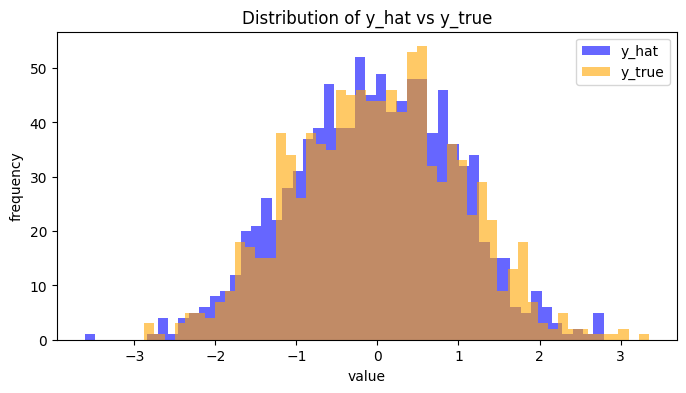

In [15]:
import matplotlib.pyplot as plt

# 如果在 GPU，要先搬回 CPU
y_hat_np = y_hat.detach().cpu().numpy().flatten()
y_true_np = y_true.detach().cpu().numpy().flatten()

plt.figure(figsize=(8,4))

# 畫 y_hat 的直方圖
plt.hist(y_hat_np, bins=50, alpha=0.6, color='blue', label='y_hat')

# 畫 y_true 的直方圖
plt.hist(y_true_np, bins=50, alpha=0.6, color='orange', label='y_true')

plt.legend()
plt.xlabel("value")
plt.ylabel("frequency")
plt.title("Distribution of y_hat vs y_true")
plt.show()


---

---

# Statistic Analysis
目標: 看y_hat跟y_true的母群是否相似 (POV:假裝不知道y_true是normal來的)


In [16]:
import numpy as np
from scipy.stats import ks_2samp, epps_singleton_2samp, levene, ttest_ind

In [17]:
# 1) 取資料（確保 shape 與裝置一致）
y_hat_np  = y_hat.detach().cpu().numpy().ravel()
y_true_np = y_true.detach().cpu().numpy().ravel()

# 2) 可選：讓樣本數一致（避免樣本量差異影響）
n = min(len(y_hat_np), len(y_true_np))
rng = np.random.default_rng(0)
y_hat_s  = rng.choice(y_hat_np,  n, replace=False)
y_true_s = rng.choice(y_true_np, n, replace=False)

# 3) 兩樣本分布檢定
ks_stat, ks_p = ks_2samp(y_hat_s, y_true_s)                 # KS 檢定（對整體CDF差異敏感）
es_stat, es_p = epps_singleton_2samp(y_hat_s, y_true_s)     # Epps–Singleton（對形狀差更敏感）

# 4) 均值、變異的簡單比較（非必要，但有助判讀差異來源）
t_stat, t_p   = ttest_ind(y_hat_s, y_true_s, equal_var=False)
lev_stat, lev_p = levene(y_hat_s, y_true_s)                 # 變異是否相等

print(f"KS: stat={ks_stat:.3f}, p={ks_p:.3g}")
print(f"Epps–Singleton: stat={es_stat:.3f}, p={es_p:.3g}")
print(f"t-test (means): stat={t_stat:.3f}, p={t_p:.3g}")
print(f"Levene (variances): stat={lev_stat:.3f}, p={lev_p:.3g}")

# 5) 幾個摘要統計（幫助你直覺比較）
def summary(a, name):
    print(name, "mean=", np.mean(a), "std=", np.std(a), "kurtosis≈", (np.mean(((a-np.mean(a))/np.std(a))**4)-3))
summary(y_hat_s,  "y_hat")
summary(y_true_s, "y_true")


KS: stat=0.029, p=0.795
Epps–Singleton: stat=2.400, p=0.663
t-test (means): stat=-1.069, p=0.285
Levene (variances): stat=0.009, p=0.925
y_hat mean= -0.042450994 std= 1.0111259 kurtosis≈ -0.19492722
y_true mean= 0.0060456446 std= 1.0159264 kurtosis≈ -0.17552614


## 10/01統計檢驗結果
**目標：** p>0.05

- **Kolmogorov–Smirnov (KS)**: stat = 0.050, p = 0.702  
  → 無法拒絕同分佈假設。

- **Epps–Singleton test**: stat = 2.559, p = 0.634  
  → 無顯著差異。

- **t-test (均值比較)**: stat = 1.082, p = 0.280  
  → 均值無顯著差異。

- **Levene test (變異數比較)**: stat = 0.125, p = 0.724  
  → 變異數無顯著差異。

---

### 數據摘要

|            | Mean    | Std      | Kurtosis  |
|------------|---------|----------|-----------|
| **y_hat**  | 0.146   | 1.017    | -0.066    |
| **y_true** | 0.067   | 1.041    | 0.249     |

- 均值差距約 **0.08**，相對於 \(\sigma \approx 1\) 屬於**很小**。  
- 標準差幾乎一致。  
- 峰態：\(y_{\hat{}}\) 略偏平頂（尾部略薄），但幅度很小。

---

### 結論

- CDF 圖顯示 \(y_{\hat{}}\) 與 \(y_{\text{true}}\) 幾乎重合。  
- 各項檢驗 p 值皆遠大於 0.05，無顯著差異。  
- 整體而言，模型生成分佈與真實分佈高度一致。

---


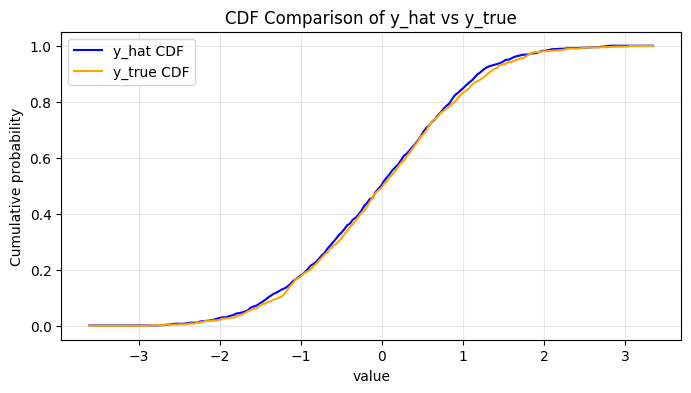

In [18]:
def plot_cdf_comparison(y_hat, y_true, bins=200):
    # 轉 numpy
    y_hat_np  = y_hat.detach().cpu().numpy().ravel()
    y_true_np = y_true.detach().cpu().numpy().ravel()

    # 共同範圍
    lo = min(y_hat_np.min(), y_true_np.min())
    hi = max(y_hat_np.max(), y_true_np.max())
    grid = np.linspace(lo, hi, bins)

    # 計算 CDF
    y_hat_cdf  = np.searchsorted(np.sort(y_hat_np), grid, side="right") / len(y_hat_np)
    y_true_cdf = np.searchsorted(np.sort(y_true_np), grid, side="right") / len(y_true_np)

    
    plt.figure(figsize=(8,4))
    plt.plot(grid, y_hat_cdf, label="y_hat CDF", color="blue")
    plt.plot(grid, y_true_cdf, label="y_true CDF", color="orange")
    plt.xlabel("value")
    plt.ylabel("Cumulative probability")
    plt.title("CDF Comparison of y_hat vs y_true")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


plot_cdf_comparison(y_hat, y_true)
